In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torchaudio
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import matplotlib.pyplot as plt



c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_process(path):
    df = pd.read_csv(f'{path}/dem-info.csv')
    # fix 66* string value in Age column
    df['Age'] = df['Age'].apply(lambda x: x.replace('66*', '66'))
    df['Age'] = df['Age'].astype(int)

    # get_file_names
    for ext in ["CTD", "PFT", 'SFT']:
        df[f'{ext}_wav'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'__{ext}.wav'
        df[f'{ext}_txt'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'__{ext}.txt'

    return df

def load_process_cleaned(path):
    df = pd.read_csv(f'{path}/dem-info.csv')
    # fix 66* string value in Age column
    df['Age'] = df['Age'].apply(lambda x: x.replace('66*', '66'))
    df['Age'] = df['Age'].astype(int)

    # get_file_names
    for ext in ["CTD", "PFT", 'SFT']:
        df[f'{ext}_wav'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'_{ext}_clean.wav'
        df[f'{ext}_txt'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'_{ext}.txt'

    return df

process_path = './data/PROCESS-V1'
df = load_process(process_path)
df_clean = load_process_cleaned(process_path)

In [31]:
w2v2processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h')
w2v2model = Wav2Vec2Model.from_pretrained('facebook/wav2vec2-base-960h')

def extract_wav2vec_features(wav_path):
    waveform, sample_rate = torchaudio.load(wav_path)
    inputs = w2v2processor(waveform.squeeze(), sampling_rate=sample_rate, return_tensors='pt', padding=True)
    with torch.no_grad():
        outputs = w2v2model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# df_train_w2v_ctd = [extract_wav2vec_features(a) for a in tqdm(df['CTD_wav'].values)]
# np.savetxt('./data/features/process-ctd-w2v-feature.csv', df_train_w2v_ctd, delimiter=',')
# df_train_w2v_pft = [extract_wav2vec_features(a) for a in tqdm(df['PFT_wav'].values)]
# np.savetxt('./data/features/process-pft-w2v-feature.csv', df_train_w2v_pft, delimiter=',')
# df_train_w2v_sft = [extract_wav2vec_features(a) for a in tqdm(df['SFT_wav'].values)]
# np.savetxt('./data/features/process-sft-w2v-feature.csv', df_train_w2v_sft, delimiter=',')

# df_train_w2v_ctd_clean = [extract_wav2vec_features(a) for a in tqdm(df_clean['CTD_wav'].values)]
# np.savetxt('./data/features/process-ctd-w2v-feature-clean.csv', df_train_w2v_ctd_clean, delimiter=',')
# df_train_w2v_pft_clean = [extract_wav2vec_features(a) for a in tqdm(df_clean['PFT_wav'].values)]
# np.savetxt('./data/features/process-pft-w2v-feature-clean.csv', df_train_w2v_pft_clean, delimiter=',')
# df_train_w2v_sft_clean = [extract_wav2vec_features(a) for a in tqdm(df_clean['SFT_wav'].values)]
# np.savetxt('./data/features/process-sft-w2v-feature-clean.csv', df_train_w2v_sft_clean, delimiter=',')

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
ctd_features = pd.read_csv("./data/features/process-ctd-w2v-feature.csv", header=None)
pft_features = pd.read_csv("./data/features/process-pft-w2v-feature.csv", header=None)
sft_features = pd.read_csv("./data/features/process-sft-w2v-feature.csv", header=None)
ctd_features_clean = pd.read_csv("./data/features/process-ctd-w2v-feature-clean.csv", header=None)
pft_features_clean = pd.read_csv("./data/features/process-pft-w2v-feature-clean.csv", header=None)
sft_features_clean = pd.read_csv("./data/features/process-sft-w2v-feature-clean.csv", header=None)

# features = pd.concat([ctd_features, pft_features, sft_features], axis=1, ignore_index=False)
# features_age = pd.concat([ctd_features, pft_features, sft_features, df['Age']], axis=1, ignore_index=False)
features = pd.concat([ctd_features_clean, pft_features_clean, sft_features_clean, df['Age']], axis=1, ignore_index=False)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.003253,0.012992,-0.163744,-0.084796,0.087190,-0.090259,0.045076,-0.037846,0.124404,-0.168263,...,0.216278,-0.055814,-0.128297,0.133410,-0.296492,0.012681,-0.014239,-0.187281,0.089036,-0.072723
1,-0.002395,0.029186,-0.069594,-0.078840,0.028335,-0.085554,0.099651,-0.032535,0.089528,-0.216302,...,0.251672,-0.052651,-0.159125,0.025071,-0.196396,0.004242,-0.005280,-0.116822,0.043190,-0.073734
2,-0.006404,-0.012126,-0.127825,-0.077657,0.115470,-0.098001,0.037812,-0.022039,0.149606,-0.179180,...,0.295949,-0.055049,-0.102552,0.060535,-0.360190,0.004535,-0.010676,-0.162854,0.065965,0.017577
3,-0.016816,0.014021,-0.083507,-0.074056,0.103046,-0.108064,0.065136,-0.022134,0.082620,-0.223469,...,0.254498,-0.053133,-0.097718,0.068370,-0.333786,0.000430,-0.013473,-0.205957,0.039094,-0.046835
4,0.017339,0.021742,-0.096287,-0.067787,0.078644,-0.092364,0.052734,-0.032368,0.127862,-0.234539,...,0.298998,-0.056346,-0.076428,0.140896,-0.370974,0.004321,-0.013916,-0.154732,0.051434,0.016290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,-0.018529,0.010242,-0.114072,-0.064128,0.111092,-0.104329,0.020467,-0.031954,0.120439,-0.216457,...,0.245013,-0.054892,-0.056020,0.063990,-0.364455,0.003838,-0.014973,-0.066629,0.033734,-0.012276
153,-0.028247,0.001736,-0.125703,-0.072783,0.088279,-0.100271,0.031011,-0.029419,0.116721,-0.198037,...,0.279148,-0.056585,-0.074231,0.148753,-0.381153,0.000621,-0.012204,-0.105748,0.041957,-0.041234
154,-0.002975,-0.001624,-0.090661,-0.070024,0.123992,-0.103203,0.035485,-0.029634,0.077841,-0.217874,...,0.281695,-0.053436,-0.160001,0.027999,-0.378877,0.003098,-0.011002,-0.235753,0.052996,-0.068844
155,-0.011860,-0.003911,-0.033524,-0.058523,-0.001292,-0.112339,0.034990,-0.022210,0.036531,-0.221914,...,0.217491,-0.054876,-0.180776,0.015504,-0.368391,0.002872,-0.013063,-0.242063,0.033260,-0.109300


In [36]:
y, string_classes = pd.factorize(df['Class'])
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)
# X_train_clean, X_test_clean, _, _ = train_test_split(features_clean, y, test_size=0.2, random_state=42)
# X_train_age, X_test_age, _, _ = train_test_split(features, y, test_size=0.2, random_state=42)

X_tensor_train = torch.tensor(X_train.values, dtype=torch.float32)
# X_tensor_train_clean = torch.tensor(X_train_clean.values, dtype=torch.float32)
y_tensor_train = torch.tensor(y_train, dtype=torch.long)

display(y)
display(string_classes)

array([0, 0, 0, 0, 0, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1,
       2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 1, 2, 2, 0, 2, 1, 1, 2, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0,
       0, 2, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 1, 0, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2], dtype=int64)

Index(['MCI', 'Dementia', 'HC'], dtype='object')

Accuracy: 0.375
Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.40      0.30        10
           1       0.33      0.50      0.40         2
           2       0.58      0.35      0.44        20

    accuracy                           0.38        32
   macro avg       0.38      0.42      0.38        32
weighted avg       0.46      0.38      0.39        32



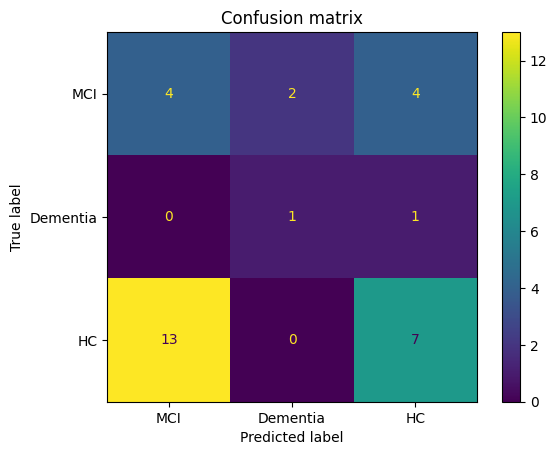

In [86]:
dataset = TensorDataset(X_tensor_train, y_tensor_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

train_model = True

class FCNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FCNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

if train_model:
    fcnn_model = FCNN(input_dim=2304, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(fcnn_model.parameters(), lr=0.001)

    for epoch in range(1000):
        for batch in dataloader:
            X_batch, y_batch = batch
            outputs = fcnn_model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model_save_path = "./models/fcnn_model.pth"
    torch.save(fcnn_model.state_dict(), model_save_path)

X_tensor_test = torch.tensor(X_test.values , dtype=torch.float32)

with torch.no_grad():
    outputs = fcnn_model(X_tensor_test)

_, fcnn_pred = torch.max(outputs, 1)

print("Accuracy:", accuracy_score(y_test, fcnn_pred))
print("Classification Report:\n", classification_report(y_test, fcnn_pred))
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, fcnn_pred, labels=range(len(string_classes))), display_labels=string_classes).plot()
cmd.ax_.set_title('Confusion matrix')
plt.show()


In [91]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

param_grid_svm = {
    'C': [1, 10], 
    'gamma': [0.001, 0.01, 1],     
    }

grid_svm = GridSearchCV(SVC(kernel='linear', class_weight={0: 1, 1: 50, 2: 1}, random_state=42), param_grid_svm, cv=5, scoring="accuracy")
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=SVC(class_weight={0: 1, 1: 50, 2: 1}, kernel='linear',
                           random_state=42),
             param_grid={'C': [1, 10], 'gamma': [0.001, 0.01, 1]},
             scoring='accuracy')

Cross-Validation Accuracy (5-fold): [0.52 0.8  0.68 0.6  0.8 ]
Durchschnittliche Genauigkeit: 0.68
Accuracy: 0.625
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.00      0.00      0.00         2
           2       0.68      0.95      0.79        20

    accuracy                           0.62        32
   macro avg       0.34      0.35      0.32        32
weighted avg       0.53      0.62      0.54        32



c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


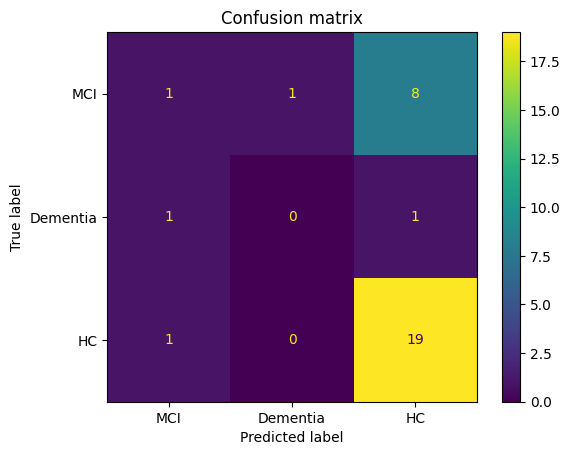

In [92]:
svm_model = grid_svm.best_estimator_
rfe = RFECV(estimator=svm_model, step=1, cv=5) 
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

svm_model.fit(X_train_rfe, y_train)
cv_scores = cross_val_score(svm_model, X_train_rfe, y_train, cv=5, scoring='accuracy')
svm_pred = cross_val_predict(svm_model, X_test_rfe, y_test, cv=5)

print(f"Cross-Validation Accuracy (5-fold): {cv_scores}")
print(f"Durchschnittliche Genauigkeit: {cv_scores.mean()}")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print("Classification Report:\n", classification_report(y_test, svm_pred))
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, svm_pred, labels=range(len(string_classes))), display_labels=string_classes).plot()
cmd.ax_.set_title('Confusion matrix')
plt.show()

In [69]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid=param_grid_xgb, scoring='accuracy', cv=5)
grid_xgb.fit(X_train.to_numpy(), y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Accuracy (5-fold): [0.56 0.56 0.68 0.6  0.6 ]
Durchschnittliche Genauigkeit: 0.6000000000000001
Accuracy: 0.4375
Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.10      0.11        10
           1       0.00      0.00      0.00         2
           2       0.59      0.65      0.62        20

    accuracy                           0.44        32
   macro avg       0.23      0.25      0.24        32
weighted avg       0.40      0.44      0.42        32



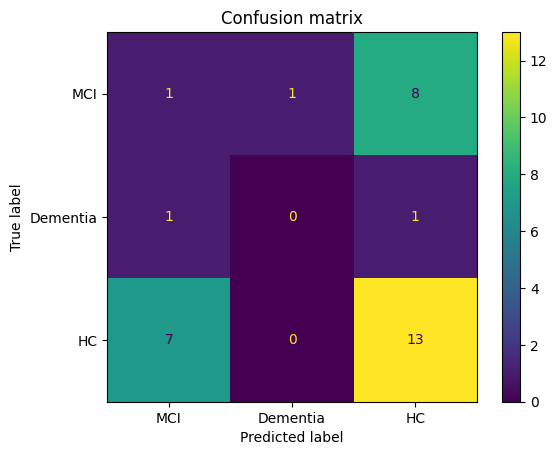

In [81]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

xgb_model = grid_xgb.best_estimator_


xgb_model.fit(X_train.to_numpy(), y_train)
cv_scores = cross_val_score(xgb_model, X_train.to_numpy(), y_train, cv=5, scoring='accuracy')
xgb_pred = cross_val_predict(xgb_model, X_test.to_numpy(), y_test, cv=5)

print(f"Cross-Validation Accuracy (5-fold): {cv_scores}")
print(f"Durchschnittliche Genauigkeit: {cv_scores.mean()}")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("Classification Report:\n", classification_report(y_test, xgb_pred))
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, xgb_pred, labels=range(len(string_classes))), display_labels=string_classes).plot()
cmd.ax_.set_title('Confusion matrix')
plt.show()

In [93]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 10, 2: 1}), param_grid=param_grid_rf, scoring='accuracy', cv=5)
grid_rf.fit(X_train.to_numpy(), y_train)

c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 1, 1: 10, 2: 1},
                                              random_state=42),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Accuracy (5-fold): [0.44 0.68 0.72 0.56 0.72]
Durchschnittliche Genauigkeit: 0.624
Accuracy: 0.59375
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.10      0.14        10
           1       0.00      0.00      0.00         2
           2       0.64      0.90      0.75        20

    accuracy                           0.59        32
   macro avg       0.30      0.33      0.30        32
weighted avg       0.48      0.59      0.51        32



c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Text(0.5, 1.0, 'Confusion matrix')

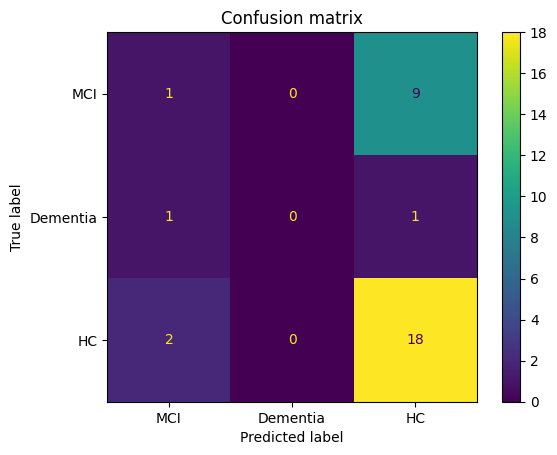

In [94]:
rf_model = grid_rf.best_estimator_
rfe = RFECV(estimator=svm_model, step=1, cv=5) 
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

rf_model.fit(X_train_rfe, y_train)
cv_scores = cross_val_score(rf_model, X_train_rfe, y_train, cv=5, scoring='accuracy')
rf_pred = cross_val_predict(rf_model, X_test_rfe, y_test, cv=5)

print(f"Cross-Validation Accuracy (5-fold): {cv_scores}")
print(f"Durchschnittliche Genauigkeit: {cv_scores.mean()}")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Classification Report:\n", classification_report(y_test, rf_pred))
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, rf_pred, labels=range(len(string_classes))), display_labels=string_classes).plot()
cmd.ax_.set_title('Confusion matrix')

In [ ]:
# import librosa
# import librosa.display
# import matplotlib.pyplot as plt
# import numpy as np

# generate_spec = False
# if generate_spec:
#     def generate_mel_spectrogram(path):
#         for index, row in df.iterrows():
#             id = row['Record-ID']
#             y, sr = librosa.load(row['SFT_wav'], sr=16000)
#             mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
#             log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

#             plt.figure(figsize=(10, 4))
#             librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
#             plt.colorbar(format='%+2.0f dB')
#             plt.title('Mel-Spectrogram')
#             plt.tight_layout()
#             plt.savefig(f"{path}/{id}/{id}_SFT_spec.png")
#             plt.close()
#     process_path = './data/PROCESS-V1'
#     generate_mel_spectrogram(process_path)


In [ ]:
#import os
# import pandas as pd

# def collect_spec_files(base_dir, ext):
#     data = []
#     for root, dirs, files in os.walk(base_dir):
#         for file in files:
#             if file.endswith(f"{ext}_spec.png"):
#                 full_path = os.path.join(root, file)
#                 data.append({f"{ext}_spec": full_path})
#     df = pd.DataFrame(data)
#     return df

# df_spec_ctd = collect_spec_files(process_path, "CTD")
# df_spec_pft = collect_spec_files(process_path, "PFT")
# df_spec_sft = collect_spec_files(process_path, "SFT")

# df_spec = pd.concat([df ,df_spec_ctd, df_spec_pft, df_spec_sft], axis=1)
# display(df_spec)

# from transformers import ViTFeatureExtractor, ViTForImageClassification

# model_name = "dhritic99/vit-base-brain-alzheimer-detection"
# feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
# model = ViTForImageClassification.from_pretrained(model_name)

# from PIL import Image
# import torch

# def predict_image(X, model, feature_extractor):
#     predictions = []
#     for file in X:
#         image = Image.open(file).convert("RGB")
#         inputs = feature_extractor(images=image, return_tensors="pt")

#         with torch.no_grad():
#             outputs = model(**inputs)
#             logits = outputs.logits
#             predicted_class = torch.argmax(logits, dim=-1)
        
#         predictions.append(predicted_class.item())
#     return predictions

# vit_pred = predict_image(df_spec['CTD_spec'], model, feature_extractor)
# y, string_classes = pd.factorize(df['Class'])

# print("Accuracy:", accuracy_score(y, vit_pred))
# print("Classification Report:\n", classification_report(y, vit_pred))
# cmd = ConfusionMatrixDisplay(confusion_matrix(y, vit_pred, labels=range(len(string_classes))), display_labels=string_classes).plot()
# cmd.ax_.set_title('Confusion matrix')
# plt.show()